<a href="https://colab.research.google.com/github/babupallam/PyTorch-Learning-Repository/blob/main/07_Recurrent_Neural_Networks_(RNNs%2C_LSTMs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### **7.1. Introduction to RNNs**
- **Recurrent Neural Networks (RNNs)** are a type of neural network designed to handle sequential data by maintaining a hidden state that captures information from previous time steps.
- Unlike feedforward networks, RNNs can leverage temporal dependencies because they have connections that loop back on themselves, allowing information to persist across time steps.

**Key Characteristics of RNNs**:
- RNNs are designed to process sequences of data, one step at a time, while maintaining a **hidden state** that is updated at each time step.
- The hidden state is shared across time steps, enabling the network to "remember" information from previous steps, which is crucial for tasks like language modeling or time series forecasting.

---



#### **7.2. RNN Architecture**


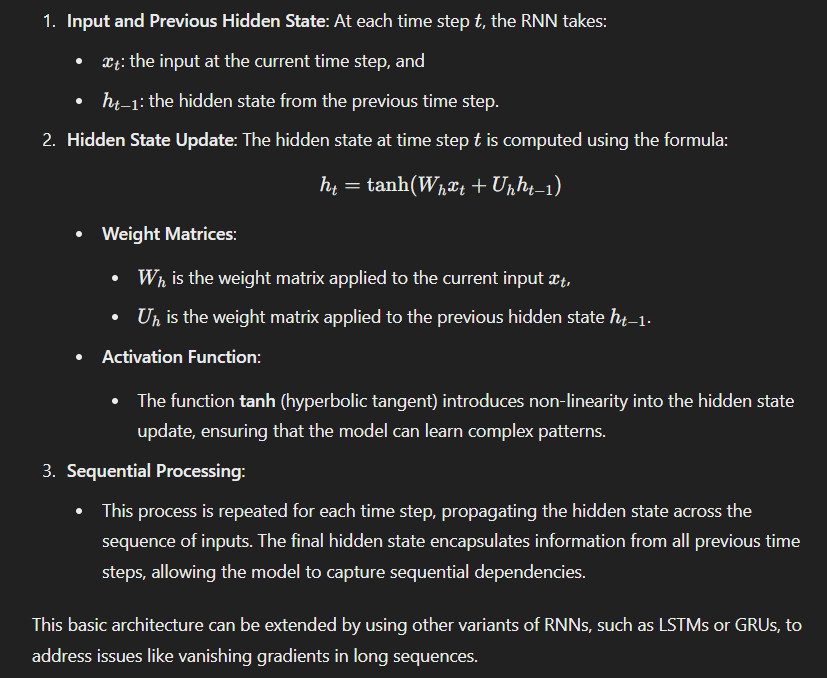


---

**7.2.1. Limitations of RNNs**
- **Vanishing Gradient Problem**: As the network backpropagates through many time steps, the gradients can become extremely small, leading to slow learning or the inability to learn long-range dependencies. This problem is particularly severe when dealing with long sequences.
- **Short-Term Memory**: Standard RNNs struggle to remember information from many time steps ago, which limits their ability to model long-term dependencies.

---



#### **7.3. Long Short-Term Memory Networks (LSTMs)**
- **LSTMs** are a special type of RNN designed to overcome the vanishing gradient problem and handle long-term dependencies. They are the most popular RNN variant and are widely used in tasks such as machine translation, speech recognition, and time series prediction.

**Key Components of LSTMs**:
- **Forget Gate**: Decides which information to discard from the previous cell state.
- **Input Gate**: Decides which information from the current input should be stored in the cell state.
- **Output Gate**: Decides what the next hidden state should be, based on the current cell state.

The key difference between LSTMs and standard RNNs is the **cell state**, which is a separate pathway through which information can flow unchanged. LSTMs use gates to control the flow of information, allowing them to remember important information over long sequences.

---



**7.3.1. LSTM Equations**

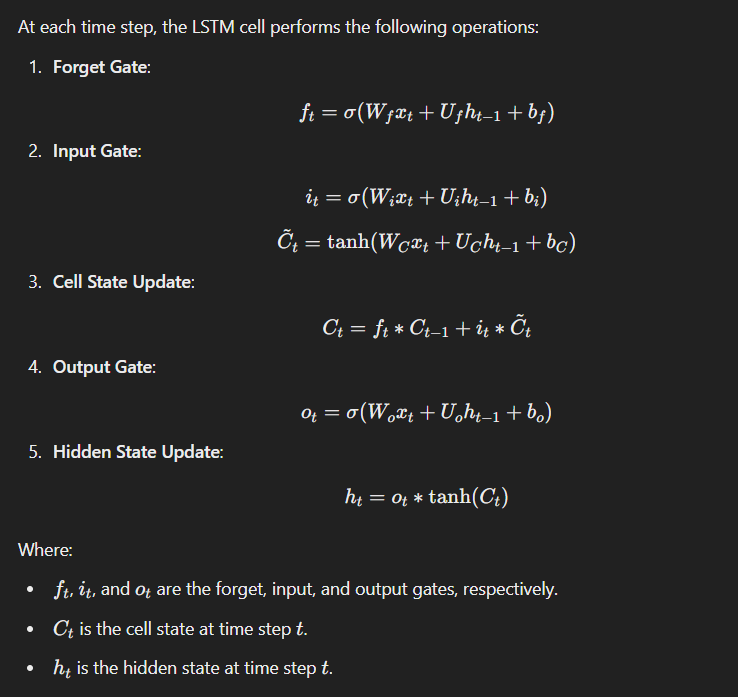


#### **7.4. Building an LSTM for Sequence Prediction**
We will now build an LSTM model for a simple time series prediction task. The goal is to predict the next value in a sequence based on the previous values.

---

**7.4.1. Example: LSTM for Time Series Prediction**

**Demonstration: Building and Training an LSTM**

In [2]:
import torch
import torch.nn as nn  # PyTorch's module for neural network layers
import torch.optim as optim  # PyTorch's module for optimization algorithms like Adam, SGD, etc.
import numpy as np  # NumPy is used for data generation

# Step 1: Generate a simple sine wave dataset for time series prediction
def generate_data(seq_length, num_sequences):
    """
    Generates a sine wave dataset for time series prediction.

    seq_length: The length of the input sequence for each sample
    num_sequences: The total number of sequences to generate

    Returns a list of tuples where each tuple contains an input sequence and its corresponding target.
    """
    x = np.linspace(0, 100, num_sequences)  # Generate evenly spaced values from 0 to 100
    data = np.sin(x)  # Generate sine wave values based on x
    sequences = []

    # Create sequences of length 'seq_length' and their corresponding targets
    for i in range(len(data) - seq_length):
        sequences.append((data[i:i + seq_length], data[i + seq_length]))  # Append tuple (input sequence, target)

    return sequences  # Return list of input-target pairs

# Step 2: Define hyperparameters
seq_length = 20  # The length of the input sequence used by the LSTM for prediction
batch_size = 16  # Number of samples per batch during training
num_epochs = 10  # Number of epochs to train the model
hidden_size = 50  # Number of hidden units in the LSTM

# Step 3: Generate the sine wave dataset
data = generate_data(seq_length, 1000)  # Generate 1000 sequences of sine wave data
# Convert input sequences and targets into tensors for PyTorch
train_data = torch.tensor([item[0] for item in data], dtype=torch.float32)  # Input sequences
train_labels = torch.tensor([item[1] for item in data], dtype=torch.float32).view(-1, 1)  # Corresponding targets

# Step 4: Create a DataLoader for batching and shuffling the data during training
# Create a dataset from input sequences and labels
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
# Use DataLoader to enable batching and shuffling during training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Step 5: Define the LSTM model for time series prediction
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the LSTM model.

        input_size: The size of the input features (1 for univariate time series)
        hidden_size: The number of hidden units in the LSTM
        output_size: The size of the output (1 for univariate prediction)
        """
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        # Define LSTM layer: input_size -> hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  # LSTM with batch_first=True (input: [batch, seq_len, features])

        # Fully connected (FC) layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer to predict the next time step value

    def forward(self, x):
        """
        Forward pass through the model.

        x: Input tensor with shape [batch_size, seq_length, input_size]

        Returns the predicted output for each input sequence.
        """
        # Initialize the hidden and cell state for LSTM with zeros
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # Hidden state
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # Cell state

        # Forward pass through the LSTM layer
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))  # LSTM output, last hidden state (h_n), and last cell state (c_n)

        # Pass the last time step output through the fully connected layer to produce the prediction
        out = self.fc(out[:, -1, :])  # Select the last time step's output for each sequence in the batch

        return out

# Step 6: Initialize the LSTM model
model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1)  # Univariate time series prediction

# Step 7: Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Step 8: Training loop
for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize running loss for each epoch
    model.train()  # Set the model to training mode

    # Iterate over batches of data in the train_loader
    for inputs, labels in train_loader:
        # Add an extra dimension to inputs to match the input format required by the LSTM [batch_size, seq_length, input_size]
        inputs = inputs.unsqueeze(-1)

        optimizer.zero_grad()  # Clear the gradients from the previous step

        # Forward pass: Get the model's predictions
        outputs = model(inputs)

        # Calculate the loss between the predicted and actual values
        loss = criterion(outputs, labels)

        # Backward pass: Compute gradients for the model's parameters
        loss.backward()

        # Update the model's weights using the optimizer
        optimizer.step()

        # Accumulate the running loss for monitoring
        running_loss += loss.item()

    # Print the average loss per epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Print when training is complete
print("Training Complete.")


Epoch [1/10], Loss: 0.2568
Epoch [2/10], Loss: 0.0050
Epoch [3/10], Loss: 0.0013
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0002
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training Complete.



**Explanation**:
- **Dataset**: We generate a simple sine wave dataset for time series prediction. The goal is to predict the next value in the sine wave based on the previous values.
- **LSTM Model**:
  - The LSTM layer processes the input sequence, and the fully connected layer produces the output (the predicted next value).
  - The model predicts the next value in the sequence based on the previous 20 values.
- **Training Loop**: The model is trained for 100 epochs, and the loss (mean squared error) is computed at each epoch.

---



#### **7.5. Applications of RNNs and LSTMs**
- **Natural Language Processing (NLP)**: RNNs and LSTMs are widely used in language modeling, machine translation, and text generation. They are particularly well-suited for sequential data where the order of words or characters matters.
- **Time Series Prediction**: LSTMs are used to predict future values in time series data, such as stock prices, weather forecasts, and sales trends.
- **Speech Recognition**: LSTMs have been applied successfully in speech-to-text systems, where the temporal dependencies in audio signals are crucial for accurate transcription.

---




#### **7.6. Observations on RNNs and LSTMs**
- **Long-Term Dependencies**: LSTMs effectively handle long-term dependencies due to their architecture, which includes gates that regulate the flow of information. This makes them suitable for tasks that require maintaining context over extended sequences, such as narrative text or complex time series data.
  
- **Performance**: RNNs, especially vanilla ones, often fail to learn effectively on long sequences due to the vanishing gradient problem. In contrast, LSTMs maintain performance across longer sequences, making them a popular choice for applications in NLP and time series analysis.

- **Computation**: While LSTMs are more capable than vanilla RNNs, they are also computationally more expensive due to their additional gates and memory cells. This can lead to longer training times and increased memory usage, especially with large datasets or deep architectures.

- **Alternative Architectures**: In recent years, other architectures such as **Gated Recurrent Units (GRUs)** have gained popularity. GRUs simplify the LSTM architecture by combining the forget and input gates into a single update gate, often yielding similar performance with reduced complexity.

---



#### **7.7. State-of-the-Art Research on RNNs and LSTMs**
- **Attention Mechanisms**: Attention mechanisms allow models to focus on different parts of the input sequence when producing output. This technique significantly improves the performance of RNNs and LSTMs in tasks such as machine translation, where the model needs to understand context from various positions in the input.

- **Transformers**: The introduction of Transformer models has revolutionized sequence modeling. Transformers eliminate the sequential nature of RNNs by using self-attention, allowing for parallelization and more efficient training. They have become the dominant architecture in NLP tasks, outperforming RNNs and LSTMs in many benchmarks.

- **Research on Hybrid Models**: There is ongoing research into combining RNNs and LSTMs with attention mechanisms or Transformer architectures to create hybrid models that leverage the strengths of both approaches. These models can handle complex sequences more effectively by maintaining the temporal structure while allowing flexible attention to different sequence parts.

- **Applications in Diverse Fields**: RNNs and LSTMs continue to find applications across various domains, including:
  - **Healthcare**: Predicting patient outcomes based on time series data from medical devices.
  - **Finance**: Forecasting stock prices or economic indicators using historical data.
  - **Entertainment**: Generating music sequences or completing storylines in interactive storytelling.

---



### Continuity to the Next Section
- In the next section, we will explore **Generative Models**, focusing on **Generative Adversarial Networks (GANs)** and **Variational Autoencoders (VAEs)**. We will discuss how these models can generate new data that resembles a training dataset, with applications in image generation, text synthesis, and more.

This section provided a comprehensive overview of RNNs and LSTMs, including their architecture, strengths, limitations, and recent advancements in the field. We highlighted their effectiveness in handling sequential data and their ongoing relevance in various applications, setting the stage for the exploration of generative models in the next section.